# Setup

## Imports

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from cycler import cycler

import matplotlib.bezier as bez

import scipy.optimize as opt

import matplotlib.patches as mpatches
import qutip as qp

import itertools

import copy

new_rc_params = {'text.usetex': True,
         'svg.fonttype': 'none',
         'font.size': 20
         }



## Important Definitions

In [79]:
class Transmon_Cavity_Abstract:
    def __init__(self, N_Transmon = 4,N_Cavity = 5):
        self.N_Transmon = N_Transmon
        self.N_Cavity = N_Cavity

        self.Transmon_Labels_LK = {'g':0, 'e':1, 'f':2, 'h':3, 'i':4, 'j':5}

        self.Transmon_Labels_NK = {}
        for  i,key in enumerate(self.Transmon_Labels_LK):
            self.Transmon_Labels_NK[i]=key

        self.op_dict = {}

        self.Build_Creation_and_Annihilation_Ops()

        
    def Build_Creation_and_Annihilation_Ops(self):
        a_T = qp.tensor(qp.destroy(self.N_Transmon), qp.identity(self.N_Cavity))
        a_C = qp.tensor(qp.identity(self.N_Transmon), qp.destroy(self.N_Cavity))


        n_T = a_T.dag()*a_T
        n_C = a_C.dag()*a_C

        self.op_dict['a_T']=a_T
        self.op_dict['a_C']=a_C
        self.op_dict['n_T']=n_T
        self.op_dict['n_C']=n_C
        def shift_mat(N):
            mat = np.zeros((N,N))
            for i in  range(N-1):
                mat[i,i+1] = 1
            return mat


        a_T_Norm  = qp.tensor(qp.Qobj(shift_mat(self.N_Transmon)), qp.identity(self.N_Cavity))
        a_C_Norm  = qp.tensor(qp.identity(self.N_Transmon), qp.Qobj(shift_mat(self.N_Cavity)))

        self.op_dict['a_T_Norm']=a_T_Norm
        self.op_dict['a_C_Norm']=a_C_Norm

    def create_state(self,i,j):
        if type(i) == str:
            i =  self.Transmon_Labels_LK[i]
        return qp.tensor(qp.fock(self.N_Transmon,i), qp.fock(self.N_Cavity, j))
    
    def q_maker(self, l):
        '''l: level which q acts on'''
        if type(l) == str:
            l =  self.Transmon_Labels_LK[l]
        fock_T_2 = qp.fock(self.N_Transmon, l)
        fock_T_3 = qp.fock(self.N_Transmon, l+1)
        proj2 = qp.tensor(fock_T_2*fock_T_2.dag(), qp.identity(self.N_Cavity))
        proj3 = qp.tensor(fock_T_3*fock_T_3.dag(), qp.identity(self.N_Cavity))

        ONE = qp.tensor(qp.identity(self.N_Transmon),  qp.identity(self.N_Cavity))

        op1 = proj3*self.op_dict['a_T_Norm'].dag()*proj2-proj2*self.op_dict['a_T_Norm']*proj3
        op2 = (ONE-proj3)*(ONE-proj2)

        return op1+op2
    
    def half_q_maker(self, l, cavity):
        '''l: level which q acts on
            cavity: level cavity acts on'''
        if type(l) == str:
            l =  self.Transmon_Labels_LK[l]
        if type(cavity)==str:
            cavity = int(cavity)
        

        cavity = qp.fock(self.N_Cavity, cavity)

        trans_i = qp.fock(self.N_Transmon, l)
        trans_ip1 = qp.fock(self.N_Transmon, l+1)

        ONE = qp.tensor(qp.identity(self.N_Transmon),  qp.identity(self.N_Cavity))

        trans_op = 1/np.sqrt(2)*(trans_i+trans_ip1)*trans_i.dag() 
        trans_op += 1/np.sqrt(2)*(-trans_i+trans_ip1)*trans_ip1.dag()
        trans_op += -trans_i.proj()-trans_ip1.proj()

        return ONE + qp.tensor(trans_op, qp.identity(self.N_Cavity))
    
    def Half_Sideband_Maker(self, l, cavity):
        if type(l)==str:
            l = self.Transmon_Labels_LK[l]
        
        if type(cavity)==str:
            cavity = int(cavity)


        fock1 = qp.tensor(qp.fock(self.N_Transmon, l), qp.fock(self.N_Cavity, cavity))
        fock2 = qp.tensor(qp.fock(self.N_Transmon, l-2), qp.fock(self.N_Cavity, cavity+1))

        proj1 = fock1*fock1.dag()
        proj2 = fock2*fock2.dag()
        


        Id = qp.tensor(qp.identity(self.N_Transmon), qp.identity(self.N_Cavity))
        
        op1 = (proj1+proj2+proj2*self.op_dict['a_C_Norm'].dag()*self.op_dict['a_T_Norm']*self.op_dict['a_T_Norm']*proj1-proj1*self.op_dict['a_C_Norm']*self.op_dict['a_T_Norm'].dag()*self.op_dict['a_T_Norm'].dag()*proj2)/np.sqrt(2)
        op2 = (Id-proj1)*(Id-proj2)

        return op1+op2
    
    def Make_Phase_Shift(self, i,j):
        if type(i)==str:
            i  =  self.Transmon_Labels_LK[i]
            
        state = qp.tensor(qp.fock(self.N_Transmon, i), qp.fock(self.N_Cavity, j))
        proj = state*state.dag()

        op1 = -proj
        op2 = -proj+qp.tensor(qp.identity(self.N_Transmon), qp.identity(self.N_Cavity))

        return op1+op2   

    def op_maker(self, op_name):
        op_name_list = op_name.split('_')
        #print(f"op_name: {op_name}, op_name_list: {op_name_list}")
        if op_name_list[0] == 'q':
            self.op_dict[op_name] = self.q_maker(op_name_list[1])
        
        if op_name_list[0] == 'sb':
            half_op = self.Half_Sideband_Maker(op_name_list[1], op_name_list[2])
            self.op_dict[op_name] = half_op*half_op
        
    
        if op_name_list[0] == 'half-q':
            self.op_dict[op_name] = self.half_q_maker(op_name_list[1], op_name_list[2])
        
        if op_name_list[0] == 'half-sb':
            half_op = self.Half_Sideband_Maker(op_name_list[1], op_name_list[2])
            self.op_dict[op_name] = half_op

    def Make_State_Plot(self, init_state, op_list, op_colors='Default', op_style='Default', Transmon_Colors='Default', arrow_radius = 0.1, arrow_rad_growth_exp = 1, dpi = 200, figsize = (7,5), width = 0.5, chi = 0.3, sep = 0.5, save = None, op_num_labels_size = 8, op_label_offset = 0, op_label_bbox_kwargs = dict(boxstyle='Circle,pad=0', facecolor ='white', edgecolor='white', alpha = 0.8), init_color = 'xkcd:minty green', final_color = 'xkcd:grapefruit', init_markers_box_style = dict(boxstyle='Circle,pad=0.25', alpha = 1), final_markers_box_style = dict(boxstyle='Square,pad=0.15', alpha = 1), label_fs = 8, init_final_fs = 8, init_label = r'$\psi_i$', final_label = r'$\psi_f$', ell_num_label_factor = 1, ell_w_fact = 0.05, ell_l_fact = 0.15, arrow_line_width = 1):
        if op_colors=='Default':
            op_colors = {}
            op_colors['q'] = {'g':'red', 'e':'blue', 'f':'green', 'h':'brown'}
            op_colors['sb'] = op_colors['q']
            op_colors['half-sb'] = op_colors['q']
            op_colors['half-q'] = op_colors['q']

        if op_style=='Default':
            op_style =  {'q': 'solid',  'sb': '--', 'half-sb':':', 'half-q':':'}
        
        if Transmon_Colors == 'Default':
            Transmon_Colors = ['red', 'blue', 'green', 'brown']
        
        
        state_history_list = []

        shape = (self.N_Transmon, self.N_Cavity)

        zero_array = np.empty(shape, dtype=object)

        state_array = np.empty_like(zero_array)

        for i in  range(shape[0]):
            for j in  range(shape[1]):
                state_array[i,j] = self.create_state(i,j)
                zero_array[i,j] = 0*state_array[i,j]

        init_array = zero_array.copy()        

        for i in  range(shape[0]):
            for j in  range(shape[1]):
                proj = state_array[i,j]*state_array[i,j].dag()
                init_array[i,j] = proj*init_state

        state_history_list.append(init_array)

        state_proj_history = []
        for n_op in range(len(op_list)):
            op_name = op_list[n_op]

            if op_name not in self.op_dict:
                self.op_maker(op_name)                        
                    
            op = self.op_dict[op_name]

            step_array =  np.empty(shape,  dtype=object)
            
            new_state_array = zero_array.copy()

            proj_list = []
            proj_list_key = []
            
            for i in  range(shape[0]):
                for j in  range(shape[1]):
                    state = state_history_list[n_op][i,j]
            
                    if state.norm()>1e-10:
                        new_state =  op*state
                        proj_array =  np.zeros(shape, dtype=complex)
                        
                        for m in  range(shape[0]):
                            for n in  range(shape[1]):
                                if qp.version.version[0]!='5':
                                    proj_array[m,n] = (state_array[m,n].dag()*new_state)[0][0]
                                if qp.version.version[0]=='5':
                                    proj_array[m,n] = (state_array[m,n].dag()*new_state)
                    
                        proj_list.append(proj_array.copy())
                        proj_list_key.append([i,j])

            proj_array = np.array(proj_list)
            for i in range(shape[0]):
                for j in range(shape[1]):
                    new_state_array[i,j] = state_array[i,j]*np.sum(proj_array[:, i,j])
            
            state_history_list.append(new_state_array.copy())
            state_proj_history.append((proj_array.copy(), np.array(proj_list_key)))

        fig, ax = plt.subplots(dpi = dpi, layout = 'tight', figsize = figsize)
        ax.set_ylim(-0.5,   self.N_Cavity)
        ax.set_xlim(-0.5, self.N_Transmon)  

        connections_counter_dict = {}

        for i in range(self.N_Transmon):
            for j in range(self.N_Cavity):
                ax.add_line(plt.Line2D([i, i+width], [j+chi*i,j+chi*i], color = Transmon_Colors[i]))
        
        for n in range(len(state_proj_history)):
            for m in range(len(state_proj_history[n][1])):
                transmon_start = state_proj_history[n][1][m][0]
                cavity_start = state_proj_history[n][1][m][1]
                
                new_state = []
                for i in range(state_proj_history[n][0][m].shape[0]):
                    for j in range(state_proj_history[n][0][m].shape[1]):
                        if np.abs(state_proj_history[n][0][m][i,j])>1e-10:
                            new_state.append([i,j])
                
                for i in range(len(new_state)):
                    transmon_end = new_state[i][0]
                    cavity_end = new_state[i][1]

                    shift = 0
                    
                    connection = str([(transmon_start,  cavity_start), (transmon_end, cavity_end)])
                    
                    if connection not in connections_counter_dict:
                        connections_counter_dict[connection] = 0

                    connections_counter_dict[connection]+=1

                    n_con =  connections_counter_dict[connection]            

                    if transmon_end<transmon_start:
                        shift = -width

                    x0 = width*(transmon_start+1)+sep*(transmon_start)+shift
                    y0 = cavity_start+chi*transmon_start

                    x1 = width*(transmon_end)+sep*(transmon_end)-shift
                    y1 = cavity_end+chi*transmon_end

                    dx = x1-x0
                    dy = y1-y0

                    str_split = op_list[n].split('_')
                    
                    ls = op_style[str_split[0]]
                    color =op_colors[str_split[0]][str_split[1]]
                    if (transmon_start==transmon_end) & (cavity_end==cavity_start):

                        x  = width*transmon_start+sep*transmon_start+width/2
                        y = cavity_start+chi*transmon_end
                        w  = ell_w_fact*(n_con+1)
                        l  = ell_l_fact*(n_con+1)

                        x0=x
                        y0 = y+l/2
                        arrow = mpatches.Ellipse((x0,y0), w, l, fill =  False, color = color, ls=ls, linewidth = arrow_line_width)
                        ax.add_patch(arrow)

                        dist = np.sqrt(dx**2+dy**2)
                        shift = 0
                        label_pos_x = x0
                        label_pos_y = y0+l*ell_num_label_factor/2#+0.045
                        
                    else:
                        rad = -arrow_radius*(n_con**arrow_rad_growth_exp)*np.sign(dx)*np.sign(dy)
                        arrow = mpatches.FancyArrowPatch((x0,y0), (x1,y1), arrowstyle='->',ls=ls, connectionstyle='arc3, rad='+str(rad), mutation_scale=10, zorder = 100, color = color, linewidth = arrow_line_width)
                        ax.add_patch(arrow)

                        # Get the path of the arrow
                        path = arrow.get_path()

                        verts = path.vertices
                        control_points = verts[0:3, :]

                        bc = bez.BezierSegment(control_points)

                        xy = bc.point_at_t(0.5+0.05*n_con)
                        label_pos_x = xy[0]
                        label_pos_y = xy[1]
                        ts = np.linspace(0,1,11)
                        x = []
                        y = []
                        for t in ts:
                            xy = bc.point_at_t(t)
                            x.append(xy[0])
                            y.append(xy[1])
                        x= np.array(x)
                        y = np.array(y)

                    #ax.annotate(n, [label_pos_x,label_pos_y-fontsize/175+op_label_offset], fontsize =  fontsize, ha ='center', va = 'center', color='black', zorder =  200, bbox=op_label_bbox_kwargs)
                    ax.annotate(n, [label_pos_x,label_pos_y+op_label_offset*np.sign(dy)], fontsize = op_num_labels_size, ha ='center', va = 'center', color='black', zorder =  200, bbox=op_label_bbox_kwargs)

                    fs = init_final_fs
                    shiftx =  -fs/1000
                    shifty = -fs/175
                    if n==0:
                        color = 'black'
                        x = width*transmon_start+sep*transmon_start+width/2+shiftx
                        y = cavity_start+transmon_start*chi+shifty
                        bbox_dat = copy.deepcopy(init_markers_box_style)
                        if "facecolor" not in bbox_dat.keys():
                            bbox_dat['facecolor']= final_color
                        if "edgecolor" not in bbox_dat.keys():
                            bbox_dat['edgecolor']= 'black'
                        ax.annotate(init_label, (x,y), color=color, fontsize = fs, ha ='center', bbox = bbox_dat)

                    if n==len(state_proj_history)-1:
                        color = 'black'
                        x = width*transmon_end+sep*transmon_end+width/2+shiftx
                        y = cavity_end+transmon_end*chi+shifty
                        bbox_dat = copy.deepcopy(final_markers_box_style)
                        
                        if "facecolor" not in bbox_dat.keys():
                            bbox_dat['facecolor']= final_color
                        if "edgecolor" not in bbox_dat.keys():
                            bbox_dat['edgecolor']= 'black'
                        ax.annotate(final_label, (x,y), color=color, fontsize = fs, ha='center', bbox = bbox_dat)

            for i in range(self.N_Transmon):
                label=r'$|N, 0\rangle$'.replace('N', self.Transmon_Labels_NK[i])
                ax.annotate(label, ((width+sep)*i+width/2, i*chi-0.4), ha =  'center', fontsize = label_fs, va = 'center') 

            for i in range(self.N_Cavity):
                label=r'$|g, N\rangle$'.replace('N', str(i))
                ax.annotate(label, (-0.3, i), ha =  'center', size = label_fs, va = 'center') 


            ax.set_axis_off()
        if type(save) == str:
            plt.savefig(save)

# Making Plots

In [80]:
model = Transmon_Cavity_Abstract(N_Transmon = 3)

## Some Configs

In [81]:
Transmon_Colors = ['black']*4

op_colors = dict(q = {'g':'lightcoral', 'e':'xkcd:bright sky blue', 'f':'xkcd:jade green'})
op_colors['sb'] = op_colors['q']
op_colors['half-sb'] = op_colors['q']
op_colors['half-q'] = op_colors['q']

op_style = {'q': 'solid', 'sb':'--', 'half-sb':':', 'half-q':':'}
op_label_bbox_kwargs = dict(boxstyle='Circle,pad=0', facecolor ='white', edgecolor='white', alpha = 0.0)
kwargs_dict = {}

kwargs_dict["dpi"]=200
kwargs_dict["figsize"]=(3,4)
kwargs_dict["op_num_labels_size"]=6
kwargs_dict["op_label_offset"]=0.0
kwargs_dict["Transmon_Colors"] = Transmon_Colors
kwargs_dict["op_colors"]=op_colors
kwargs_dict["op_style"]=op_style
kwargs_dict["label_fs"] = 7
kwargs_dict["init_final_fs"] = 10
kwargs_dict["arrow_radius"] = 0.15
kwargs_dict["arrow_rad_growth_exp"]=1.5
kwargs_dict["chi"] = 0.3
kwargs_dict["width"] = 0.5
kwargs_dict["sep"] = 0.5

kwargs_dict["op_label_bbox_kwargs"] = op_label_bbox_kwargs

kwargs_dict["init_markers_box_style"] = dict(boxstyle='Circle,pad=0.35', alpha = 1, facecolor = 'xkcd:minty green', edgecolor = "gold")
kwargs_dict["final_markers_box_style"] = dict(boxstyle='Square,pad=0.15', alpha = 1, facecolor = 'xkcd:grapefruit', edgecolor = "dodgerblue")
kwargs_dict["init_final_fs"] = 7
kwargs_dict["init_label"] = " " #r'$\psi_i$' # label for initial state marker
kwargs_dict["final_label"] = "   " #r'$\psi_f$' # label for final markers

kwargs_dict["ell_num_label_factor"] = 0.8 # This number is how far from the top the labels for the ellipsis are. 1 is at the top, lowering this number lowers the labels, raising it raises the label. Zero puts it at the center
kwargs_dict["ell_l_fact"] = 0.115 # controls ellipse height
kwargs_dict["ell_w_fact"] = 0.07 # controls ellipse width

kwargs_dict["arrow_line_width"] = 0.75

## Binomial Encoding


In [82]:
ops = ["q_e", "q_g", "sb_f_0", "q_g", "q_e", "q_g","half-sb_f_1", "q_g", "q_e", "sb_f_2", "q_g", "sb_f_0", "q_e", "sb_f_0", "q_g", "sb_f_3", "q_e", "sb_f_1"]

### Starting with $|g,0\rangle$

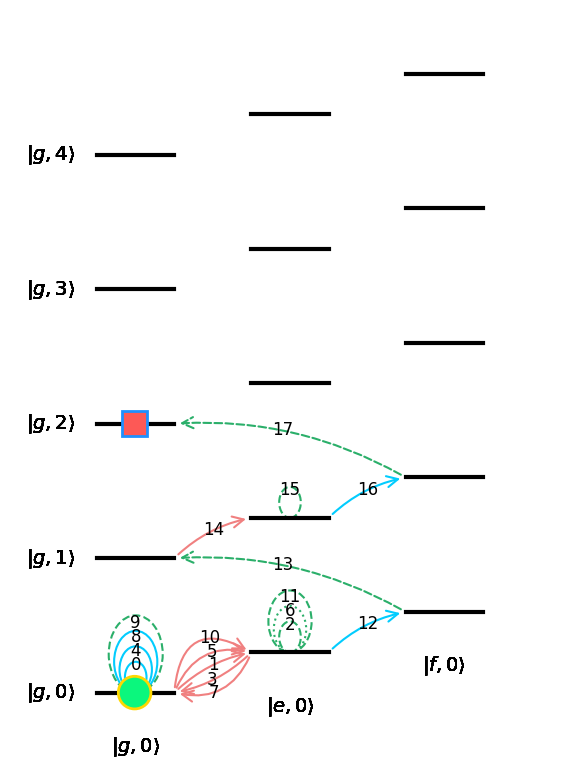

In [90]:
psi0 = model.create_state(0,0)
model.Make_State_Plot(psi0, ops, save = "g0.pdf", **kwargs_dict)

### Starting in $|e0\rangle$

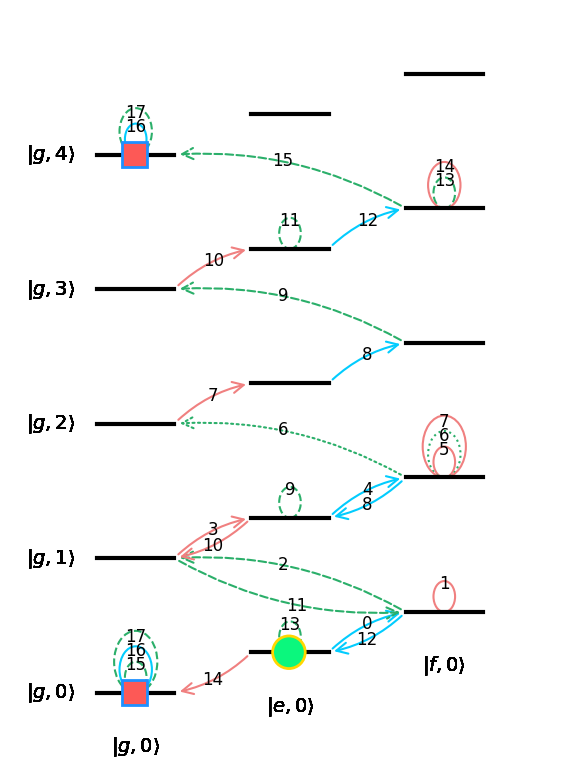

In [89]:
psi0 = model.create_state(1,0)
psi0 = psi0/psi0.norm()
model.Make_State_Plot(psi0, ops, save ="e0.pdf", **kwargs_dict)

## Prep $|0\rangle+|4\rangle$


In [86]:
ops_0p4 = ['q_g', 'half-q_e_0', 'sb_f_0', 'q_g', 'q_e', 'q_g', 'sb_f_1', 'q_g', 'q_e', 'q_g', 'sb_f_2', 'q_g', 'q_e', 'sb_f_3']

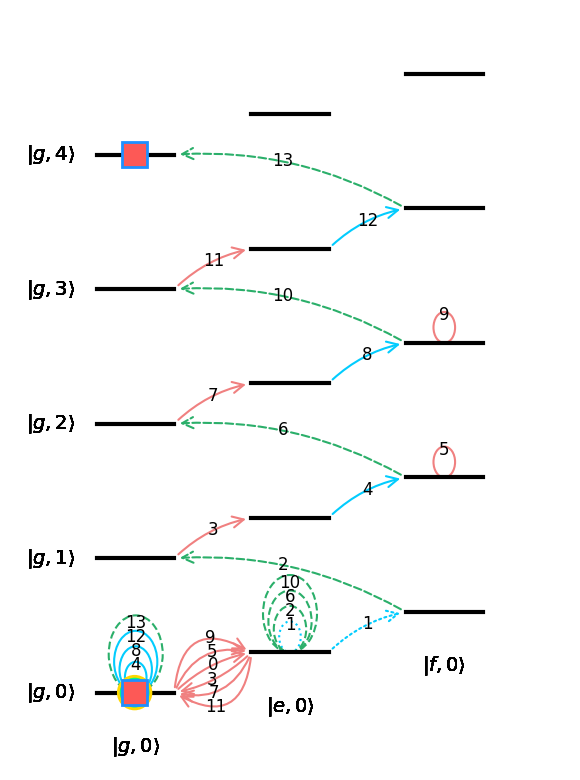

In [88]:
psi0 = model.create_state(0,0)
model.Make_State_Plot(psi0, ops_0p4, save = "0p4.pdf", **kwargs_dict)